In [1]:
import nbpresent
nbpresent.__version__

'3.0.2'

In [2]:
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display
from ipywidgets import *

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import pandas as pd
from sklearn.metrics import r2_score


### Utilities

In [3]:
# Regression plot showing predicted gF scores vs original gF scores
def regression_plot(x,y,n,title):

    # fit a curve to the data using a least squares 1st order polynomial fit
    z = np.polyfit(x,y,1)

    p = np.poly1d(z)
    fit = p(x)

    # get the coordinates for the fit curve
    c_x = [np.min(x),np.max(x)]
    c_y = p(c_x)

    # predict y values of origional data using the fit
    p_y = z[0] * x + z[1]

    # calculate the y-error (residuals)
    y_err = y - p_y

    # create series of new test x-values to predict for
    p_x = np.arange(np.min(x),np.max(x)+1,1)

    # now calculate confidence intervals for new test x-series
    mean_x = np.mean(x)         # mean of x
    DF = n - z.size                            # degrees of freedom
    t = stats.t.ppf(0.95,DF)           # used for CI and PI bands
    s_err = np.sum(np.power(y_err,2))   # sum of the squares of the residuals

    #confs = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((p_x-mean_x),2)/((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    confs = t * np.sqrt((s_err/(n-2)) * (1.0/n + (np.power((p_x-mean_x),2)/(np.sum(np.power(x - mean_x,2))))))
    # now predict y based on test x-values
    p_y = z[0]*p_x+z[1]

    # get lower and upper confidence limits based on predicted y and confidence intervals
    lower = p_y - abs(confs)
    upper = p_y + abs(confs)

    # set-up the plot
    #plt.axes().set_aspect('equal')
    plt.xlabel('Original score')
    plt.ylabel('Predicted score')
    plt.title(title)

    # plot sample data
    plt.plot(x,y,'bo')

    # plot line of best fit
    plt.plot(c_x,c_y,'r-',label='Regression line')

    # plot confidence limits
    plt.plot(p_x,lower,'b--',label='Lower confidence limit (95%)')
    plt.plot(p_x,upper,'b--',label='Upper confidence limit (95%)')

    # set coordinate limits
    plt.xlim(4,25)
    plt.ylim(5,25)

    # configure legend
    plt.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)

    # add text
    rho,p = stats.pearsonr(np.ravel(y),x)
    s = 'r={:0.2f}\np={:1.4f}'.format(rho,p)
    plt.text(20, 7, s, fontsize=12)

    
    
def mean_absolute_percentage_error(y_true, y_pred,perc=False):
    if perc:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true))
    
def absolute_percentage_error(y_true, y_pred,perc=False):
    if perc:
        return np.abs((y_true - y_pred) / y_true) * 100 
    else:
        return np.abs((y_true - y_pred) / y_true)
    
def percentage_error(y_true, y_pred,perc=False):
    if perc:
        return (y_true - y_pred) / y_true * 100 
    else:
        return (y_true - y_pred) / y_true    
    
    
def plot_hist(data,n_bins,title,xlabel):
    plt.hist(data, bins=n_bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

def plot_scatter(x,y,xlabel,ylabel):
    plt.plot(x,y,'bo')
    plt.axhline(y=0, ls='dashed')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def plot_bar_h(df,title,rotation):
    # Setting the positions and width for the bars
    pos = list(range(len(df['pearson r'])))
    width = 0.2

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(20,5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar(pos,
            #using df['pre_score'] data,
            df['pearson r'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#EE3224',
            # with label the first value in first_name
            label=df['model'].iloc[0])

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width for p in pos],
            #using df['mid_score'] data,
            df['r squared'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#F78F1E',
            # with label the second value in first_name
            label=df['model'].iloc[1])

    # Create a bar with post_score data,
    # in position pos + some width buffer,
    plt.bar([p + width*2 for p in pos],
            #using df['post_score'] data,
            df['mape'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#FFC222',
            # with label the third value in first_name
            label=df['model'].iloc[2])

    # Set the y axis label
    ax.set_ylabel('Score')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(df['model'],rotation=rotation)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
    plt.ylim([-0.1, max(df['pearson r'] + df['r squared'] + df['mape'])] )

    # Adding the legend and showing the plot
    plt.legend(['Pearson r', 'r squared', 'MAPE'], loc='upper left')
    plt.grid()
    plt.show()
    
def plot_bar_v(df,title):
    # Setting the positions and width for the bars
    pos = list(range(len(df['pearson r'])))
    width = 0.2

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(5,20))

    # Create a bar with pre_score data,
    # in position pos,
    plt.barh(pos,
            #using df['pre_score'] data,
            df['pearson r'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#EE3224',
            # with label the first value in first_name
            label=df['model'][0])

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.barh([p + width for p in pos],
            #using df['mid_score'] data,
            df['r squared'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#F78F1E',
            # with label the second value in first_name
            label=df['model'][1])

    # Create a bar with post_score data,
    # in position pos + some width buffer,
    plt.barh([p + width*2 for p in pos],
            #using df['post_score'] data,
            df['mape'],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#FFC222',
            # with label the third value in first_name
            label=df['model'][2])

    # Set the y axis label
    #ax.set_ylabel('Model Score')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_yticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_yticklabels(df['model'])

    # Setting the x-axis and y-axis limits
    plt.ylim(min(pos)-width, max(pos)+width*4)
    plt.xlim([-0.1, max(df['pearson r'] + df['r squared'] + df['mape'])] )

    # Adding the legend and showing the plot
    plt.legend(['Pearson r', 'r squared', 'MAPE'], loc='upper right')
    plt.grid()


### Import data

In [4]:
finn = sio.loadmat('res_finn.mat')
finn_ext = sio.loadmat('res_finn_ext.mat')
finn_improved_1 = sio.loadmat('res_finn_improved_1.mat')
finn_improved_2 = sio.loadmat('res_finn_improved_2.mat')
randforest = sio.loadmat('res_randomforest.mat')
randforest_ext = sio.loadmat('res_randomforest_ext.mat')
randforest_improved_1 = sio.loadmat('res_randomforest_improved_1.mat')
randforest_improved_2 = sio.loadmat('res_randomforest_improved_2.mat')
elasticnet = sio.loadmat('res_elasticnet.mat')
elasticnet_ext = sio.loadmat('res_elasticnet_ext.mat')
elasticnet_improved_1 = sio.loadmat('res_elasticnet_improved_1.mat')
elasticnet_improved_2 = sio.loadmat('res_elasticnet_improved_2.mat')
svm = sio.loadmat('res_svm.mat')
svm_ext = sio.loadmat('res_svm_ext.mat')
svm_improved_1 = sio.loadmat('res_svm_improved_1.mat')
svm_improved_2 = sio.loadmat('res_svm_improved_2.mat')
mars = sio.loadmat('res_mars.mat')
mars_ext = sio.loadmat('res_mars_ext.mat')
mars_improved_1 = sio.loadmat('res_mars_improved_1.mat')
mars_improved_2 = sio.loadmat('res_mars_improved_2.mat')
models = {}

### Percentage error

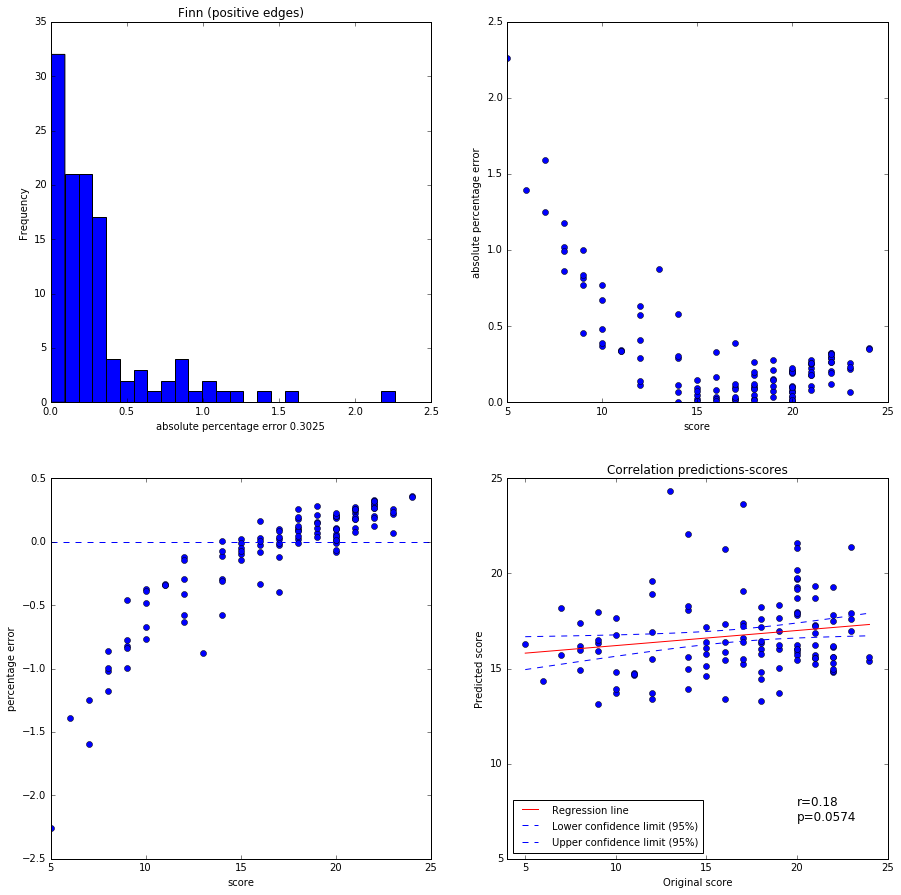

In [5]:
y_true = np.ravel(finn['finn_score'])
y_pred = np.ravel(finn['finn_preds_pos'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['finn'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Finn (positive edges)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

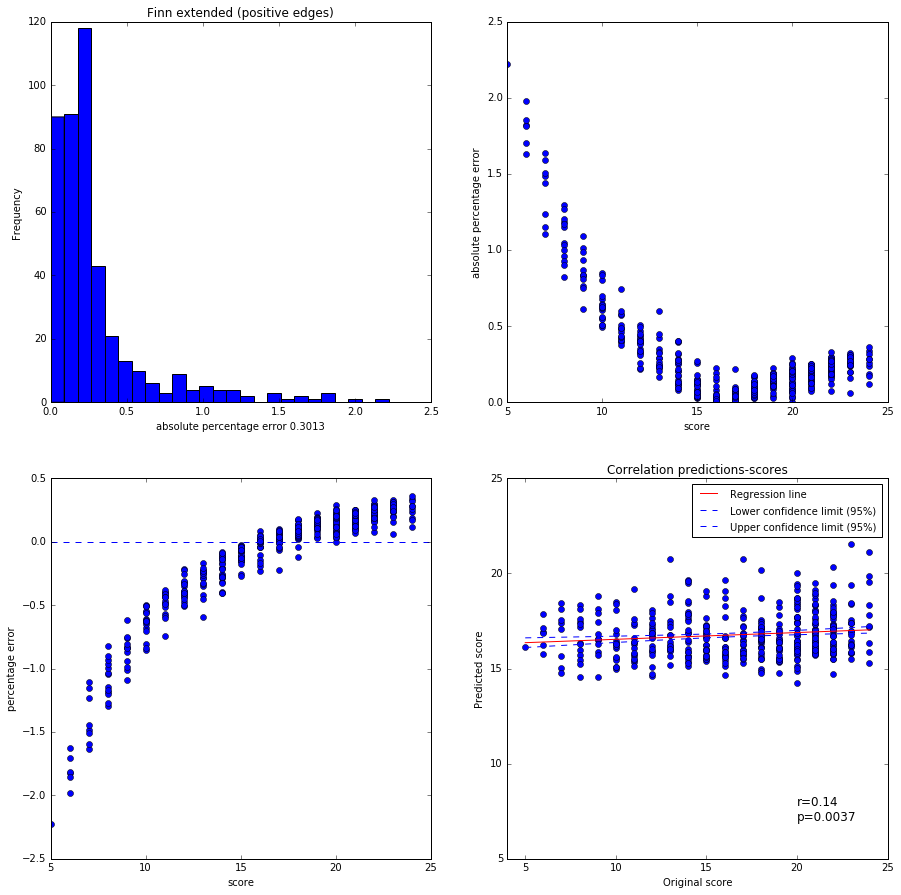

In [6]:
y_true = np.ravel(finn_ext['finn_ext_score'])
y_pred = np.ravel(finn_ext['finn_ext_preds_pos'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['finn_ext'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Finn extended (positive edges)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

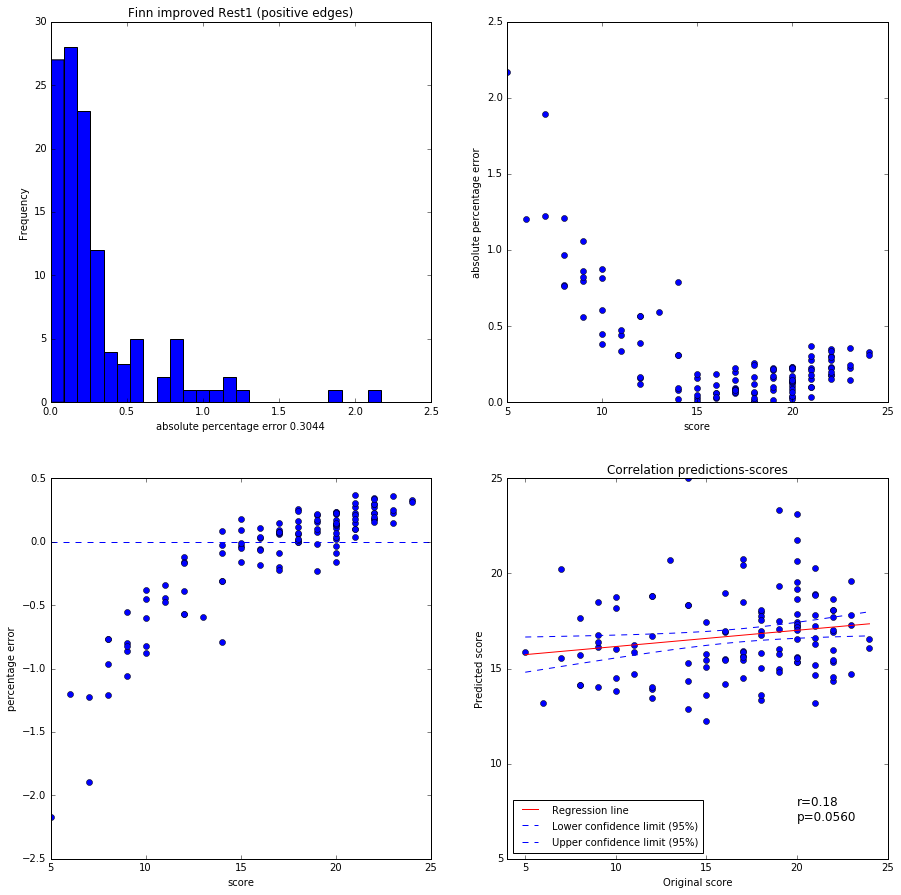

In [7]:
y_true = np.ravel(finn_improved_1['finn_improved_1_score'])
y_pred = np.ravel(finn_improved_1['finn_improved_1_preds_pos'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['finn_improved_1'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Finn improved Rest1 (positive edges)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

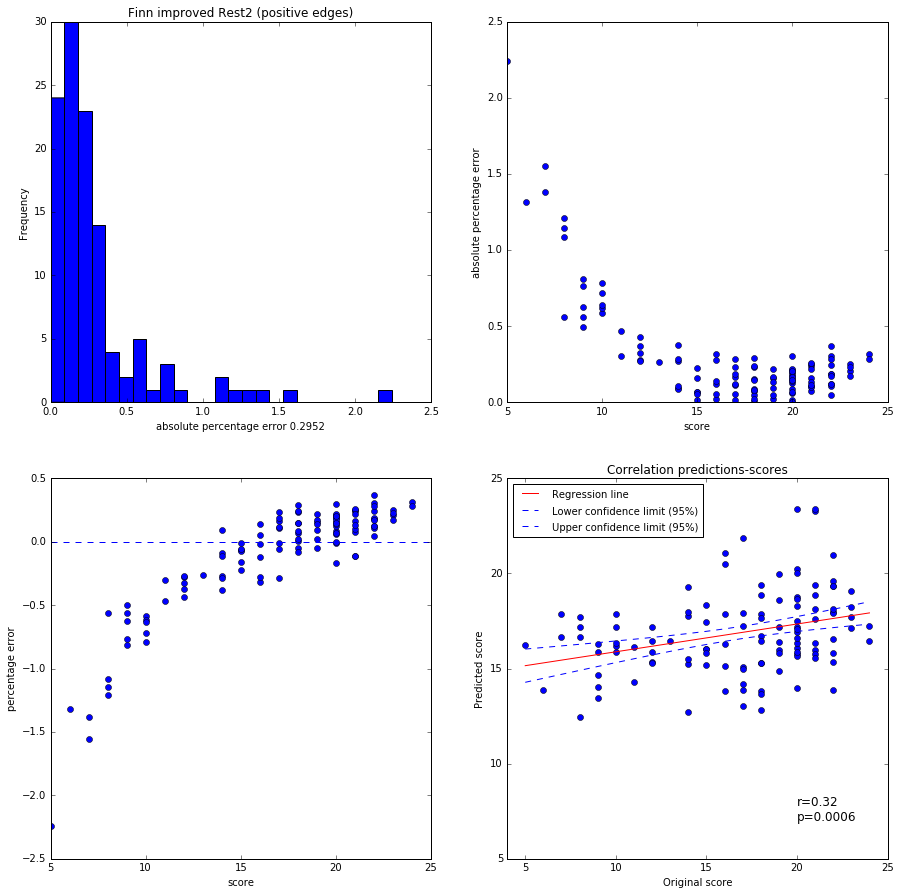

In [8]:
y_true = np.ravel(finn_improved_2['finn_improved_2_score'])
y_pred = np.ravel(finn_improved_2['finn_improved_2_preds_pos'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['finn_improved_2'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Finn improved Rest2 (positive edges)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

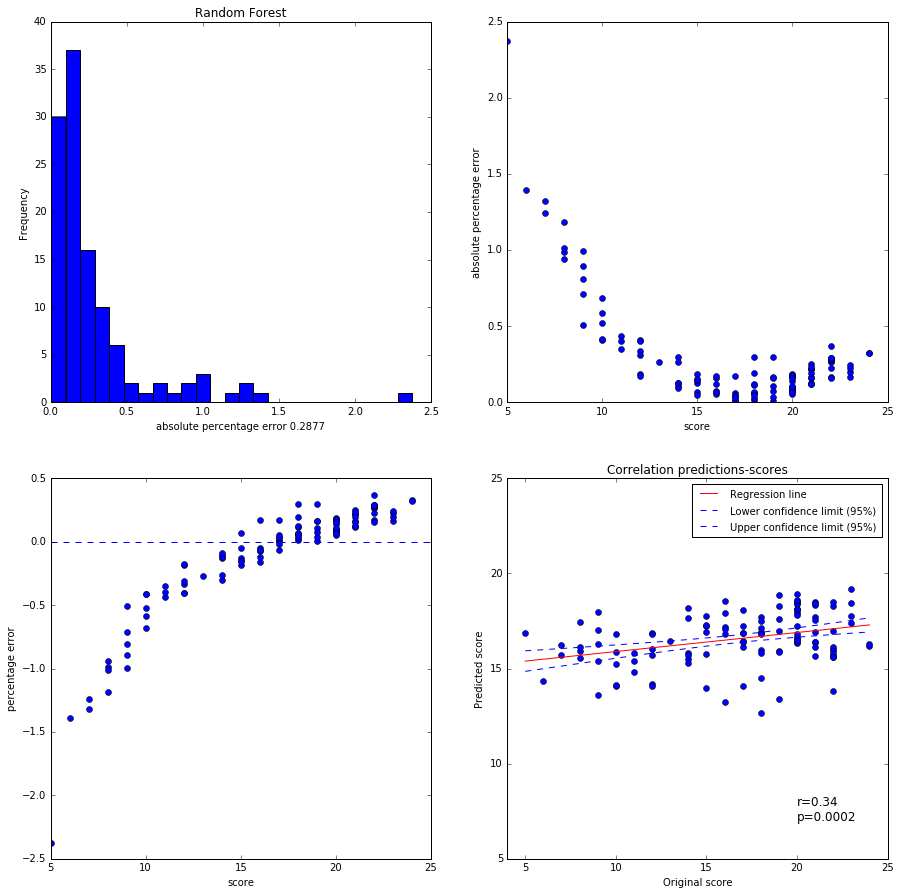

In [9]:
y_true = np.ravel(finn['finn_score'])
y_pred = np.ravel(randforest['rf_preds_allfeat'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['randforest'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

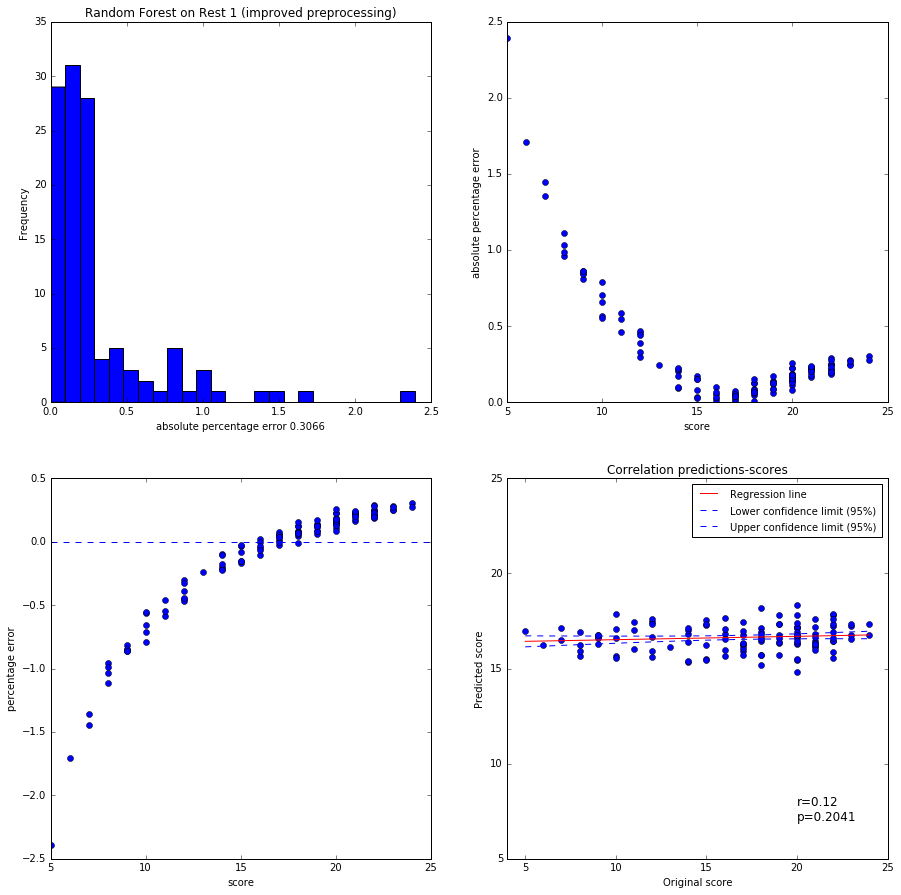

In [10]:
y_true = np.ravel(finn_improved_1['finn_improved_1_score'])
y_pred = np.ravel(randforest_improved_1['rf_improved_1_preds_allfeat'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['randforest_improved_1'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest on Rest 1 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

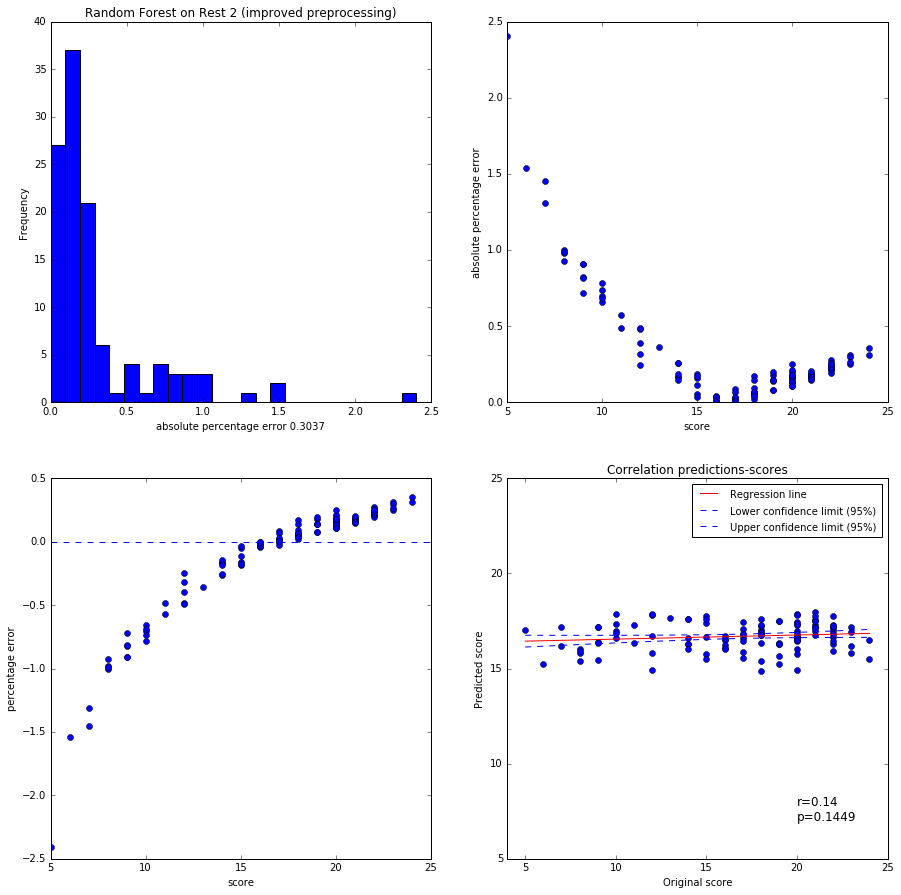

In [11]:
y_true = np.ravel(finn_improved_2['finn_improved_2_score'])
y_pred = np.ravel(randforest_improved_2['rf_improved_2_preds_allfeat'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['randforest_improved_2'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest on Rest 2 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

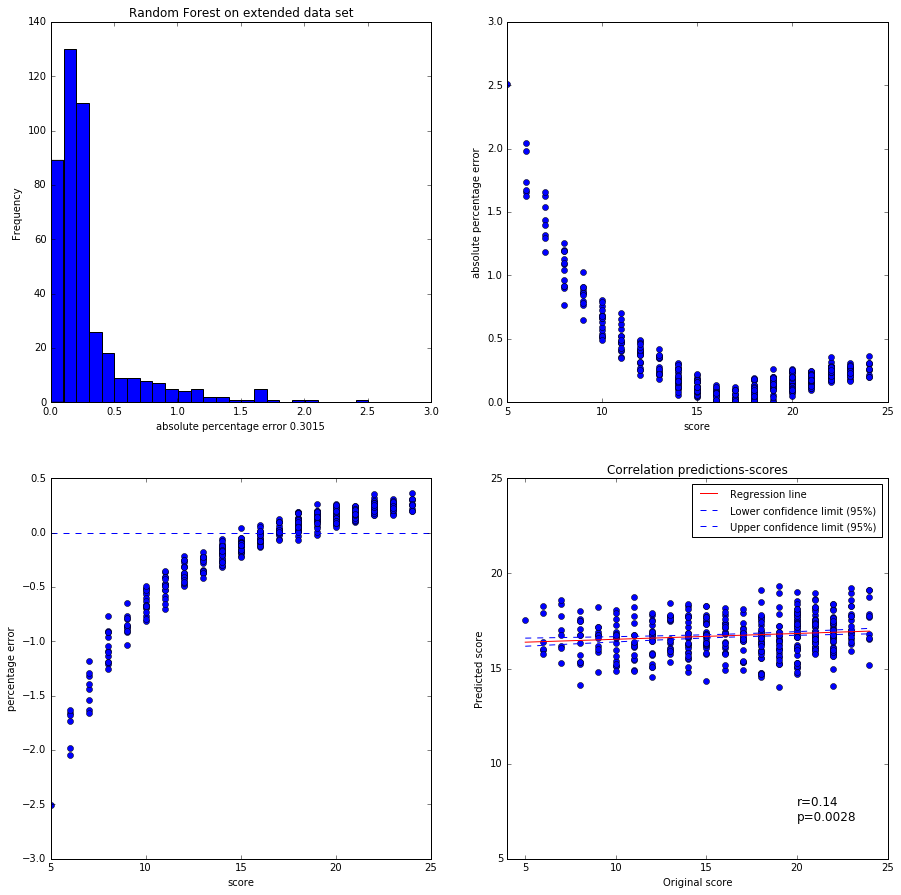

In [13]:
y_true = np.ravel(finn_ext['finn_ext_score'])
y_pred = np.ravel(randforest_ext['rf_ext_preds_allfeat'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['randforest_ext'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest on extended data set','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

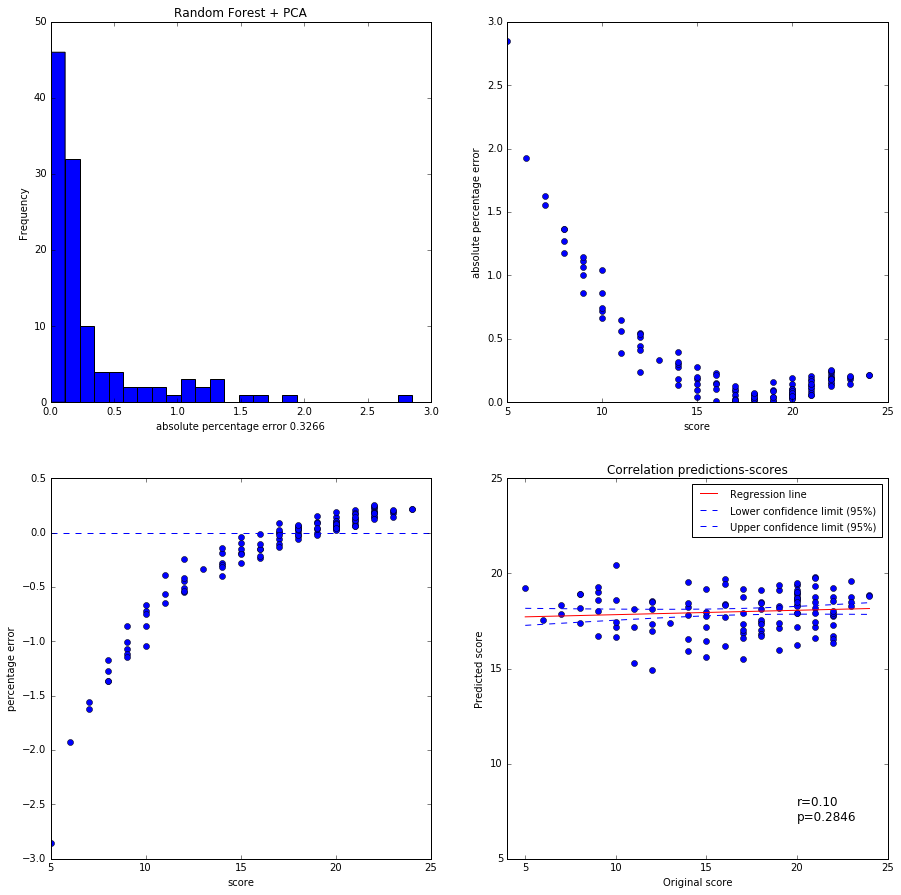

In [14]:
y_true = np.ravel(finn['finn_score'])
y_pred = np.ravel(randforest['rf_preds_pca_train'])
ape = absolute_percentage_error(y_true,y_pred)
pe = percentage_error(y_true,y_pred)
models['randforest+pca'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest + PCA','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

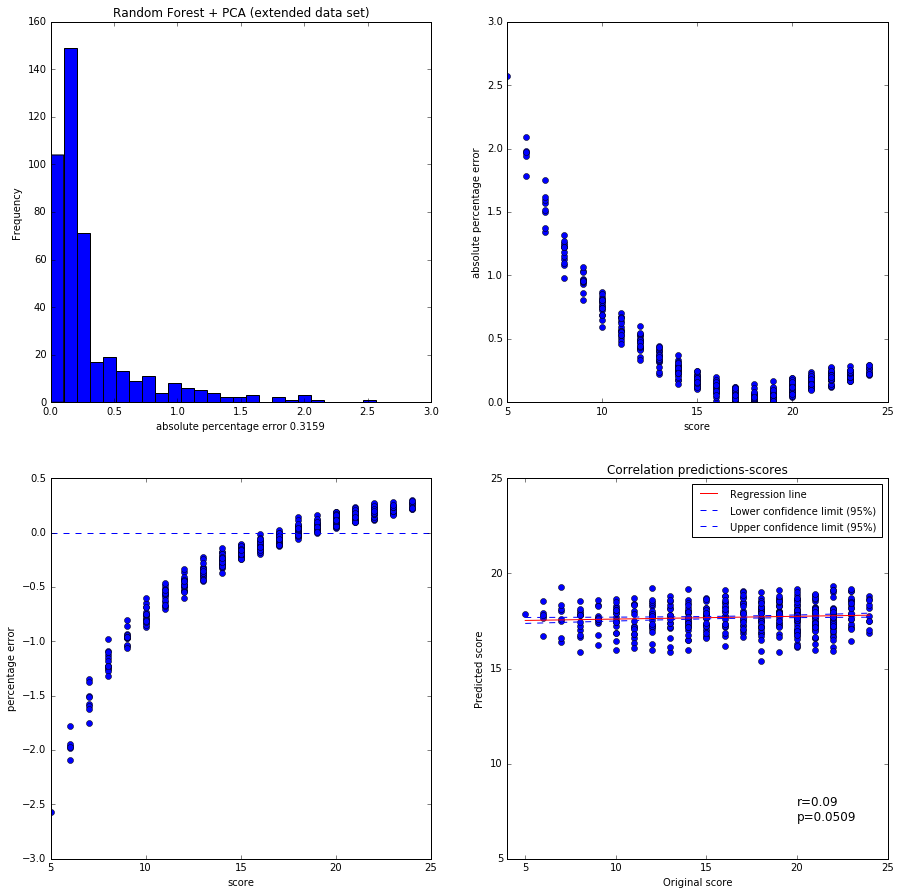

In [15]:
y_true = np.ravel(finn_ext['finn_ext_score'])
y_pred = np.ravel(randforest_ext['rf_ext_preds_pca_train'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['randforest+pca_ext'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest + PCA (extended data set)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

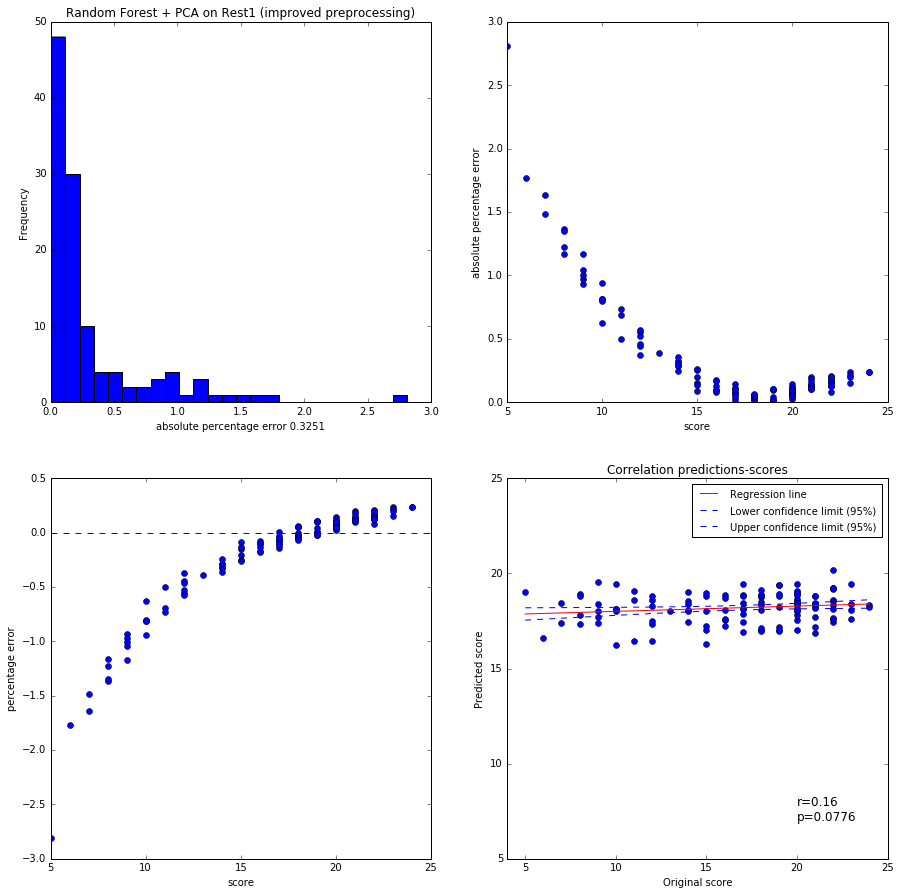

In [16]:
y_true = np.ravel(finn_improved_1['finn_improved_1_score'])
y_pred = np.ravel(randforest_improved_1['rf_improved_1_preds_pca_train'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['randforest+pca_improved_1'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest + PCA on Rest1 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

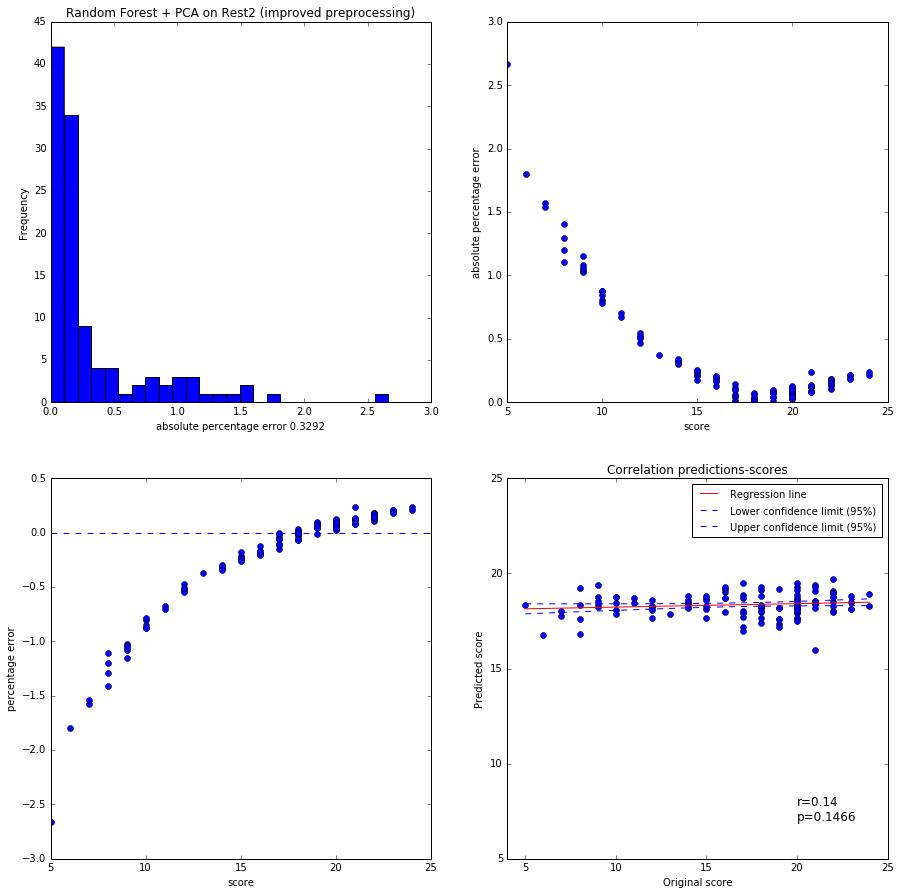

In [17]:
y_true = np.ravel(finn_improved_2['finn_improved_2_score'])
y_pred = np.ravel(randforest_improved_2['rf_improved_2_preds_pca_train'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['randforest+pca_improved_2'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Random Forest + PCA on Rest2 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

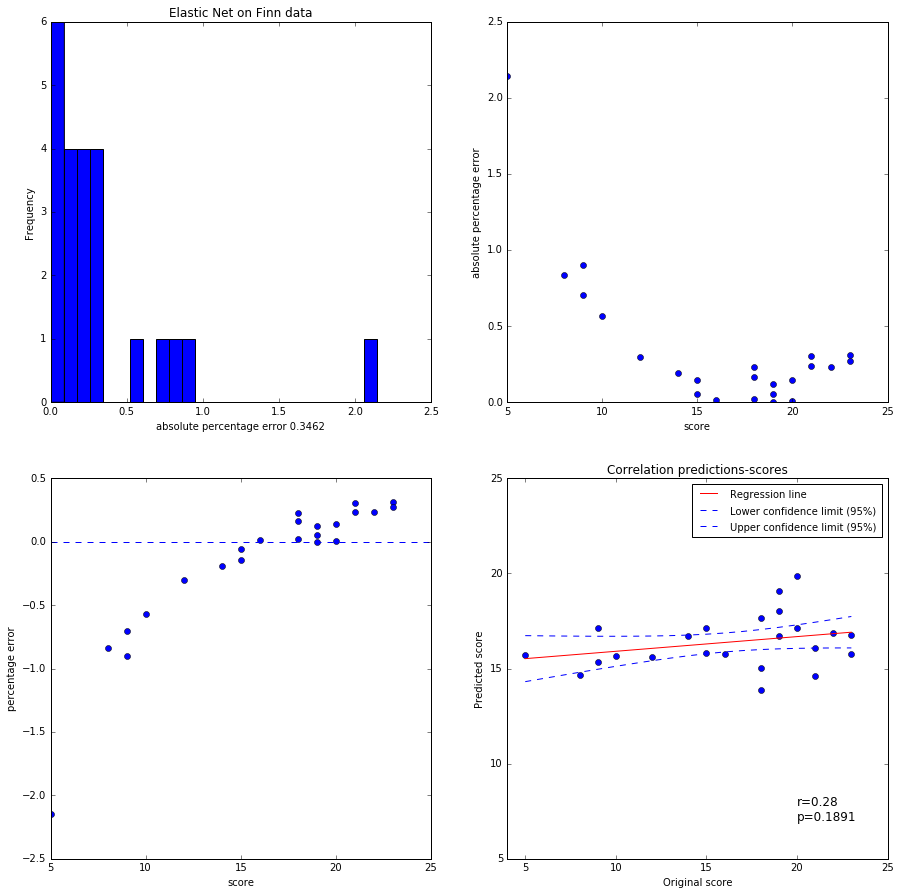

In [18]:
y_true = np.ravel(elasticnet['score'])
y_pred = np.ravel(elasticnet['res_elasticnet'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['elasticnet'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Elastic Net on Finn data','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

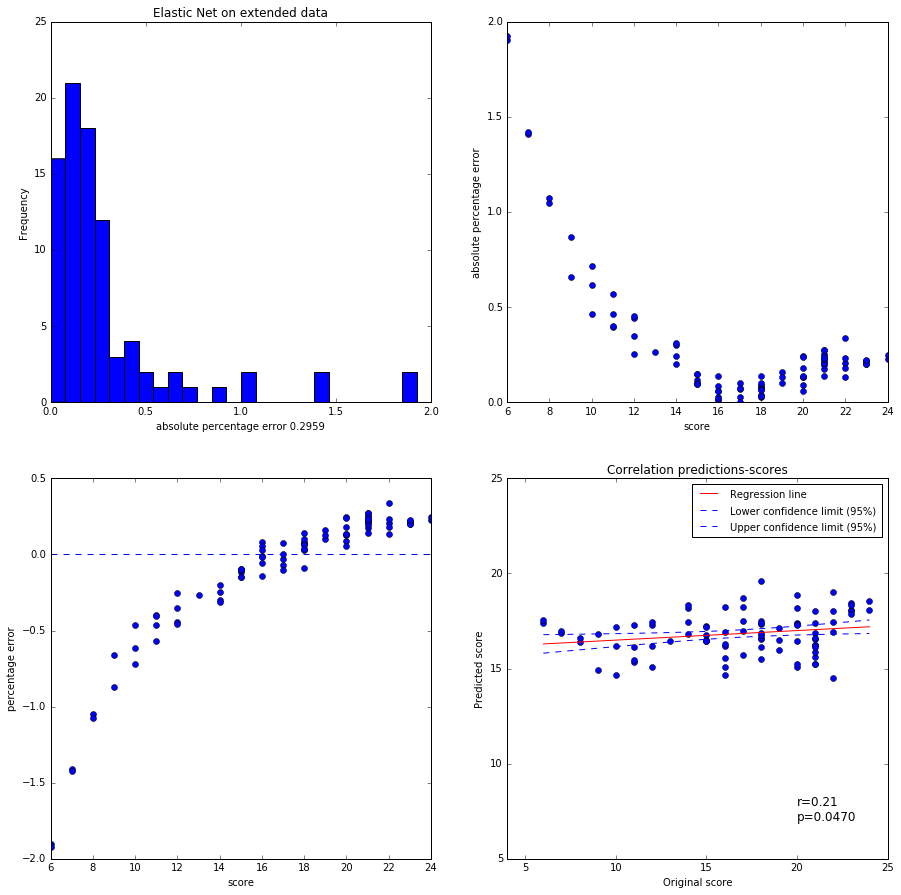

In [19]:
y_true = np.ravel(elasticnet_ext['score'])
y_pred = np.ravel(elasticnet_ext['res_elasticnet'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['elasticnet_ext'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Elastic Net on extended data','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

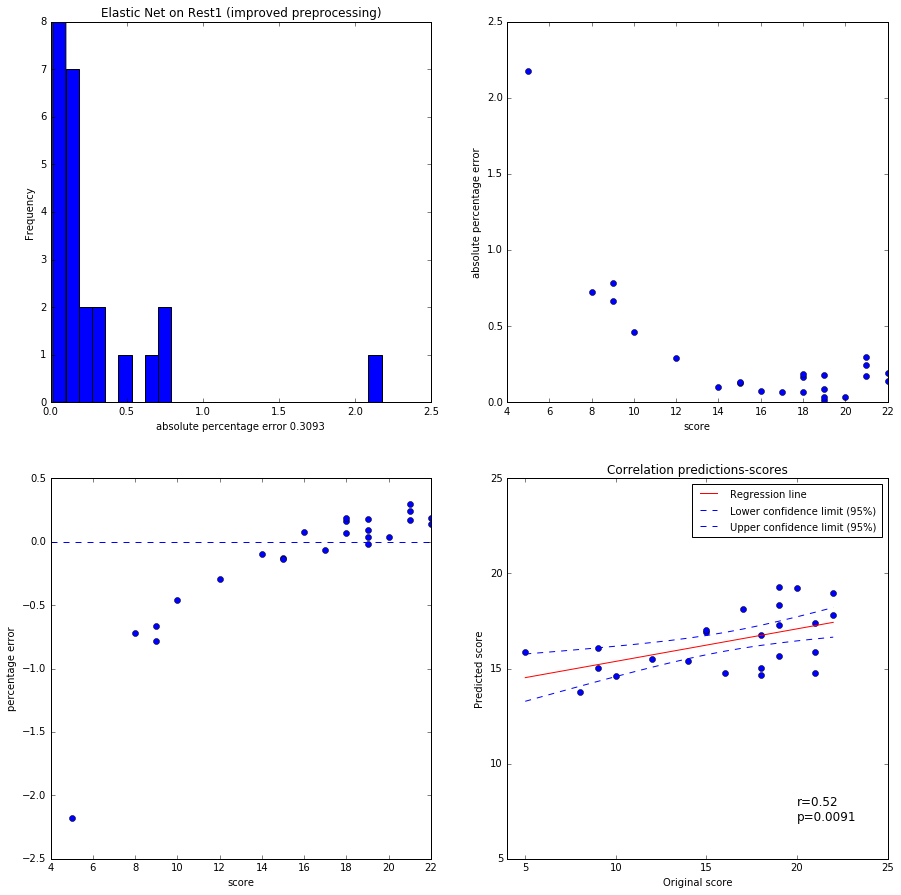

In [20]:
y_true = np.ravel(elasticnet_improved_1['score'])
y_pred = np.ravel(elasticnet_improved_1['res_elasticnet'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['elasticnet_improved_1'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Elastic Net on Rest1 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

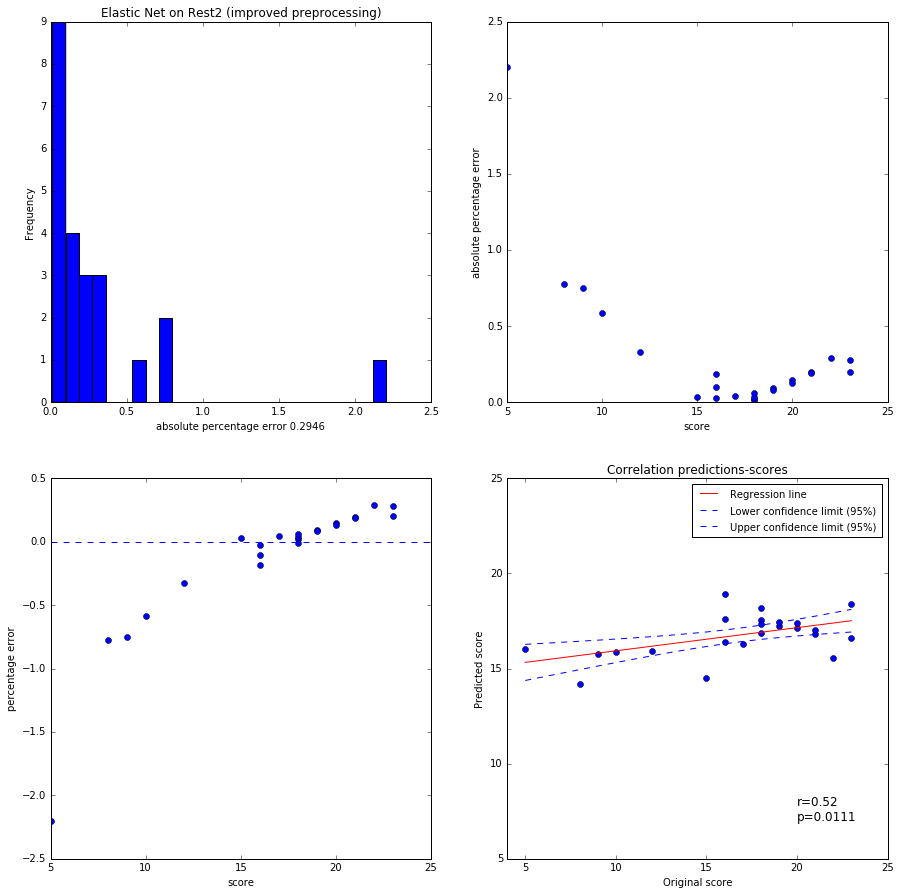

In [21]:
y_true = np.ravel(elasticnet_improved_2['score'])
y_pred = np.ravel(elasticnet_improved_2['res_elasticnet'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['elasticnet_improved_2'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Elastic Net on Rest2 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

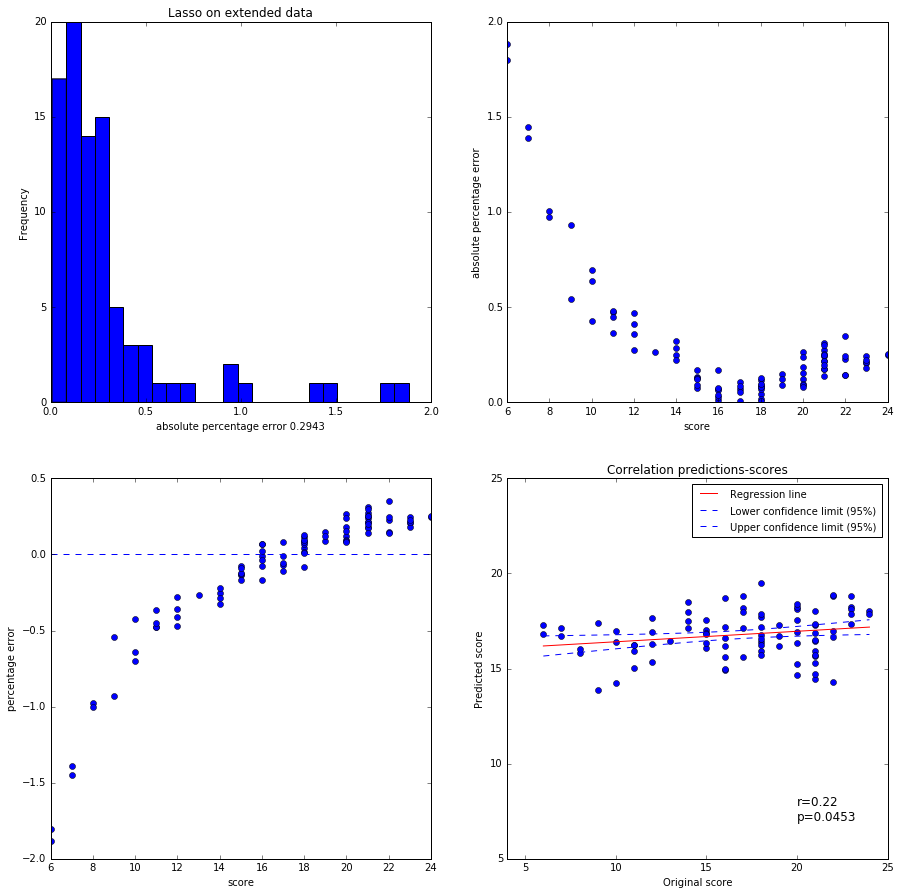

In [22]:
y_true = np.ravel(elasticnet_ext['score'])
y_pred = np.ravel(elasticnet_ext['res_lasso'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['lasso_ext'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Lasso on extended data','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

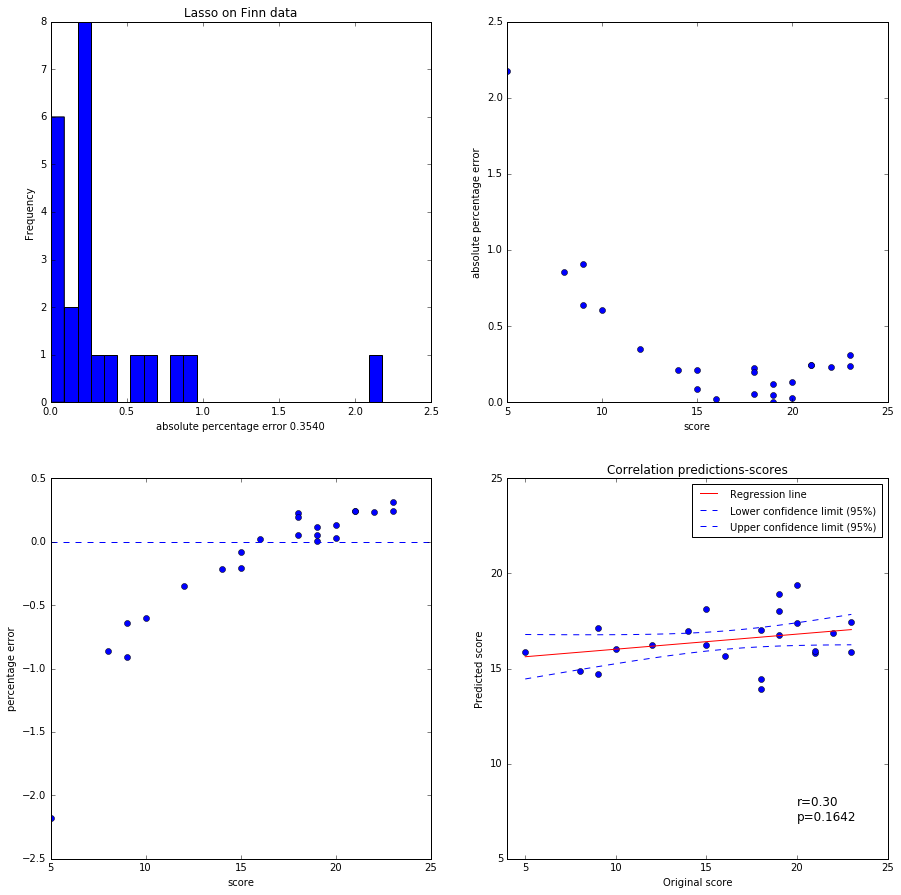

In [23]:
y_true = np.ravel(elasticnet['score'])
y_pred = np.ravel(elasticnet['res_lasso'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['lasso'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Lasso on Finn data','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

In [24]:
a = np.ravel(elasticnet_improved_1['res_lasso'])
b = np.ravel(elasticnet_improved_1['res_elasticnet'])
print(a-b)

[-1.75331248  2.27981647 -0.13981101 -4.03974383 -1.4842457   0.02529897
  0.41278327  0.52878893  0.52547436 -1.56746715 -0.30876742 -2.09709012
  0.16036397  0.8939527  -0.77610964  1.15389437  0.21455459 -0.39582081
 -2.36637275 -1.27415961  1.05527736  0.60719295 -0.38269517  1.38253128]


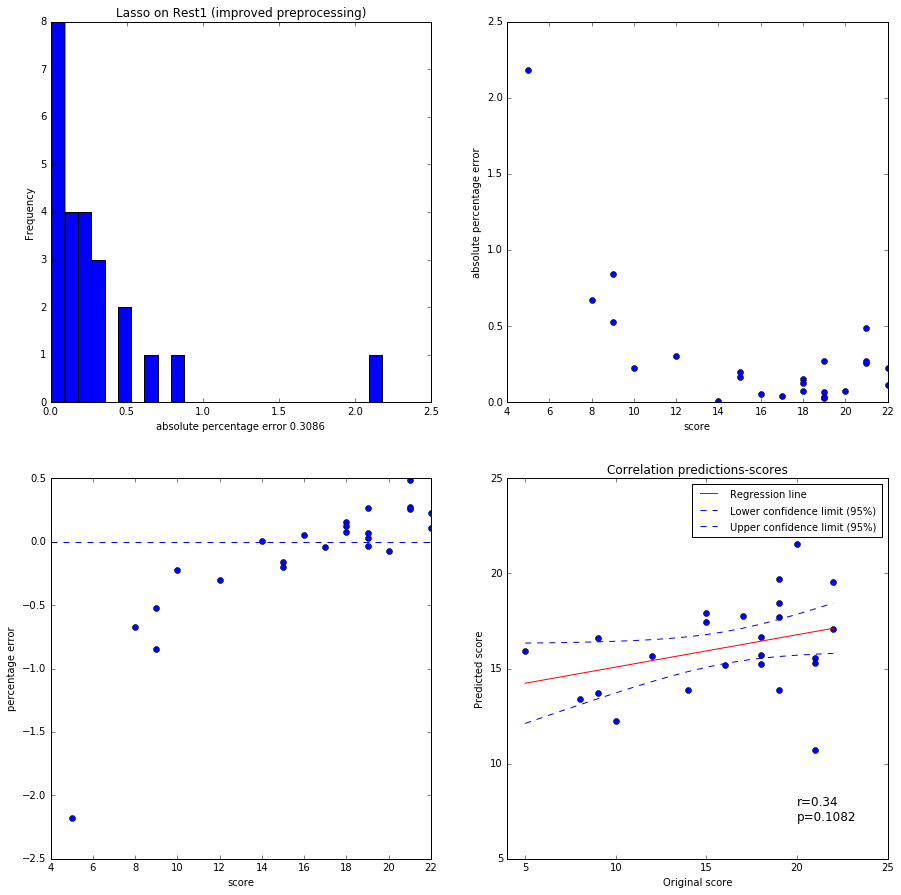

In [25]:
y_true = np.ravel(elasticnet_improved_1['score'])
y_pred = np.ravel(elasticnet_improved_1['res_lasso'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['lasso_improved_1'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Lasso on Rest1 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

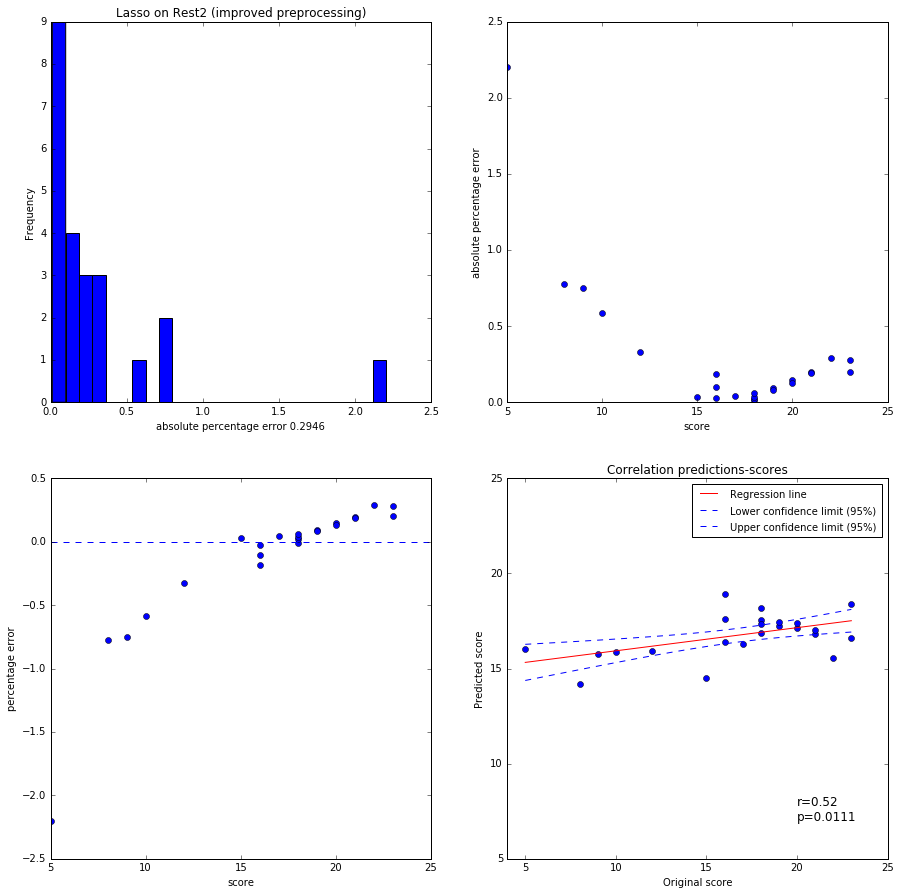

In [26]:
y_true = np.ravel(elasticnet_improved_2['score'])
y_pred = np.ravel(elasticnet_improved_2['res_lasso'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['lasso_improved_2'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'Lasso on Rest2 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

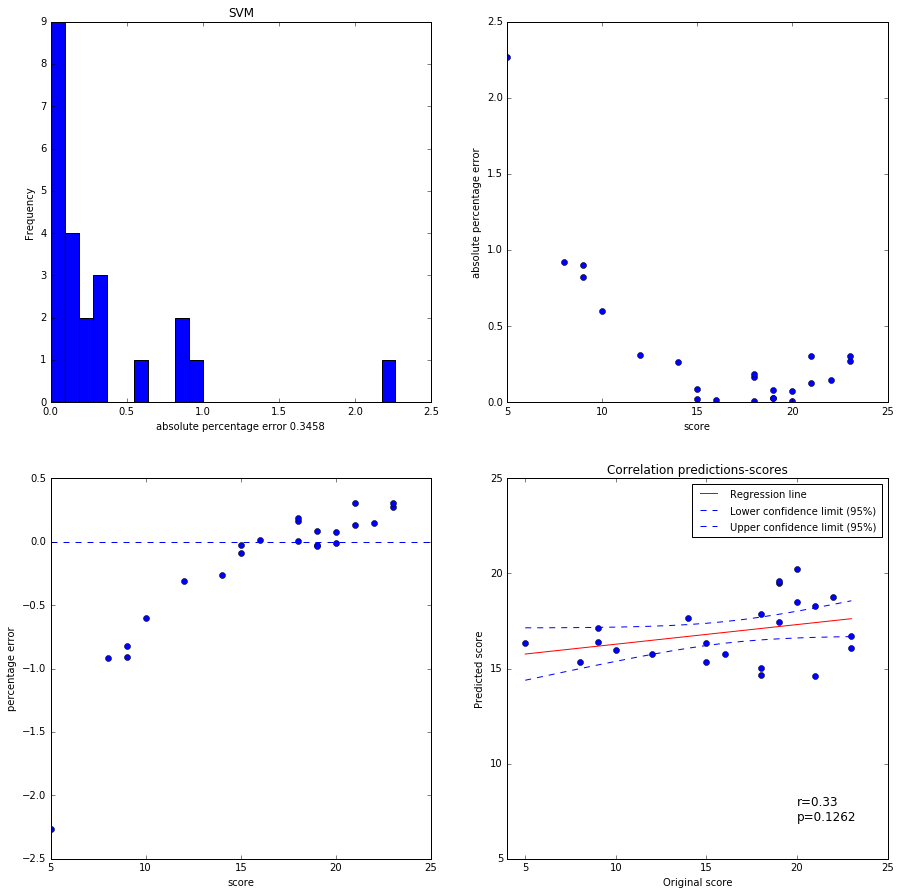

In [27]:
y_true = np.ravel(svm['score'])
y_pred = np.ravel(svm['svm_preds'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['svm'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'SVM','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

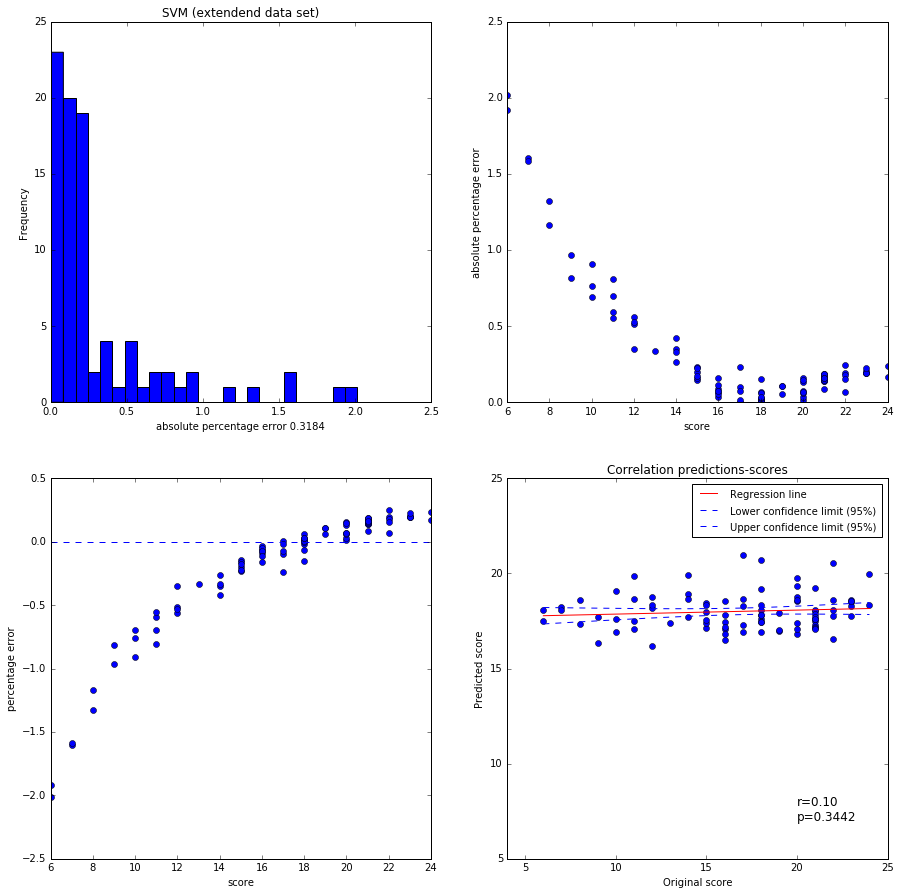

In [28]:
y_true = np.ravel(svm_ext['score'])
y_pred = np.ravel(svm_ext['svm_preds'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['svm_ext'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'SVM (extendend data set)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

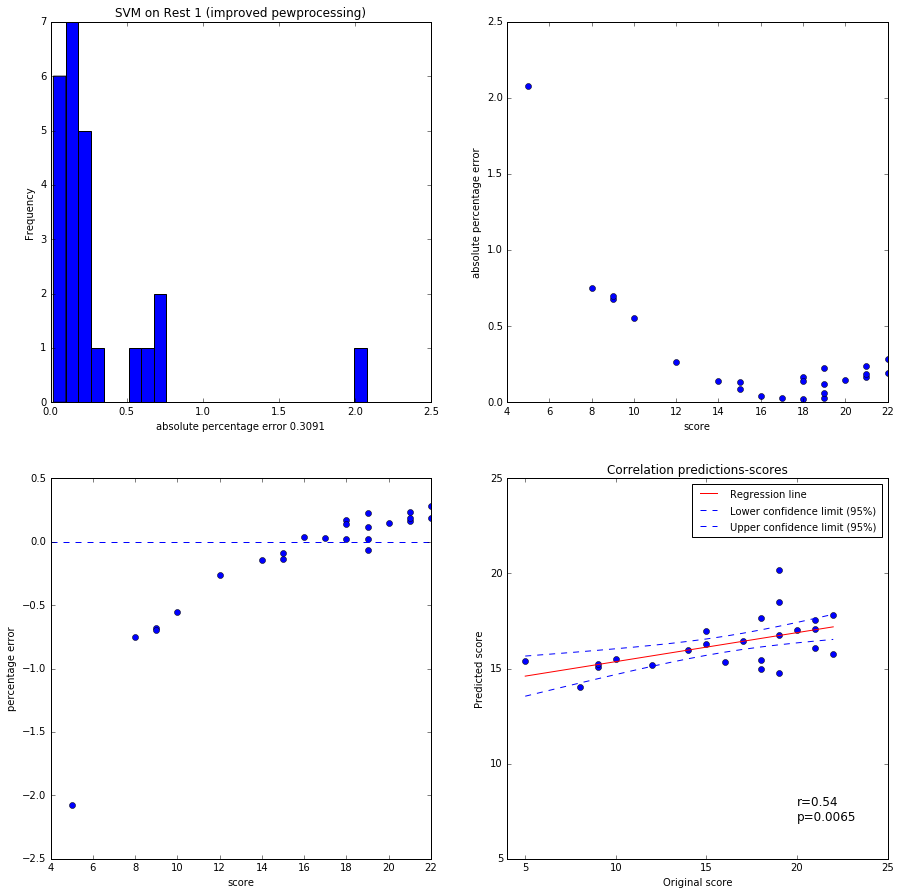

In [29]:
y_true = np.ravel(svm_improved_1['score'])
y_pred = np.ravel(svm_improved_1['svm_preds_improved_1'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['svm_improved_1'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'SVM on Rest 1 (improved pewprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

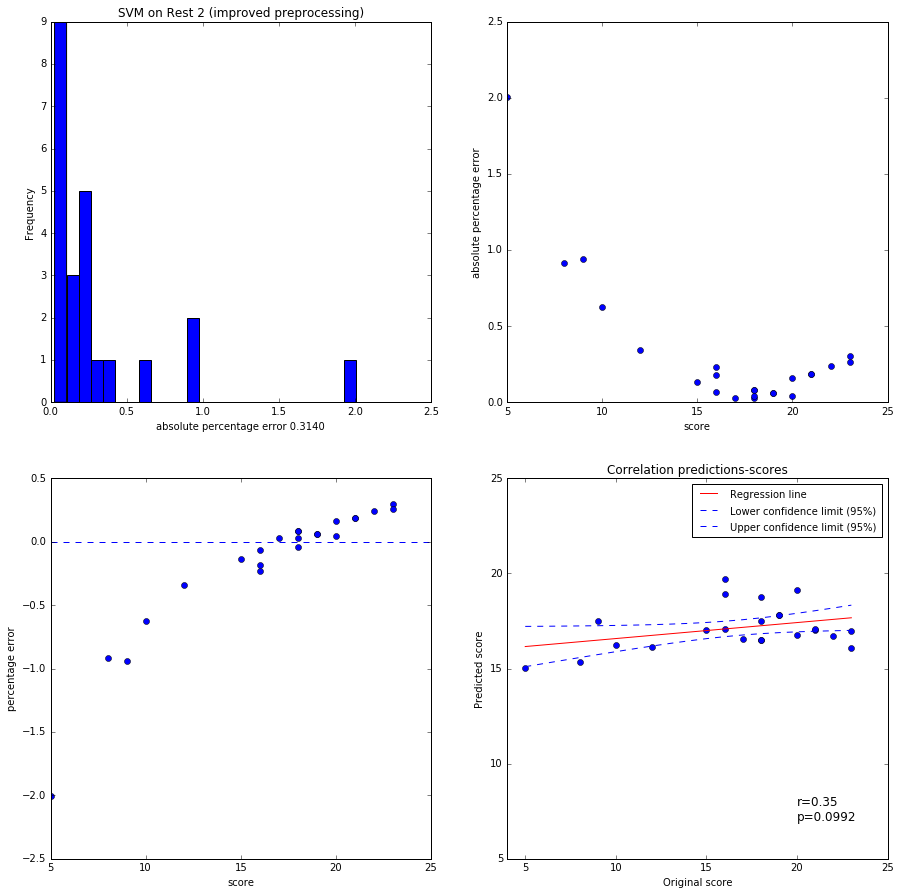

In [30]:
y_true = np.ravel(svm_improved_2['score'])
y_pred = np.ravel(svm_improved_2['svm_preds_improved_2'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['svm_improved_2'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'SVM on Rest 2 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

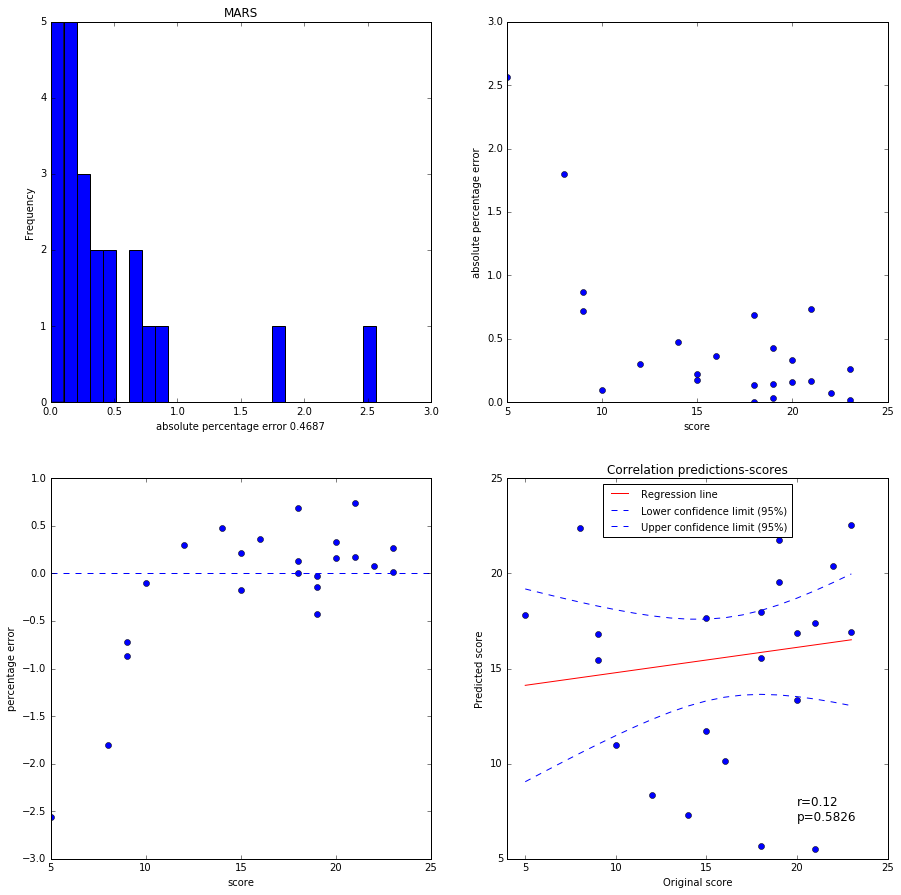

In [31]:
y_true = np.ravel(mars['score'])
y_pred = np.ravel(mars['mars_preds'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['mars'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'MARS','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

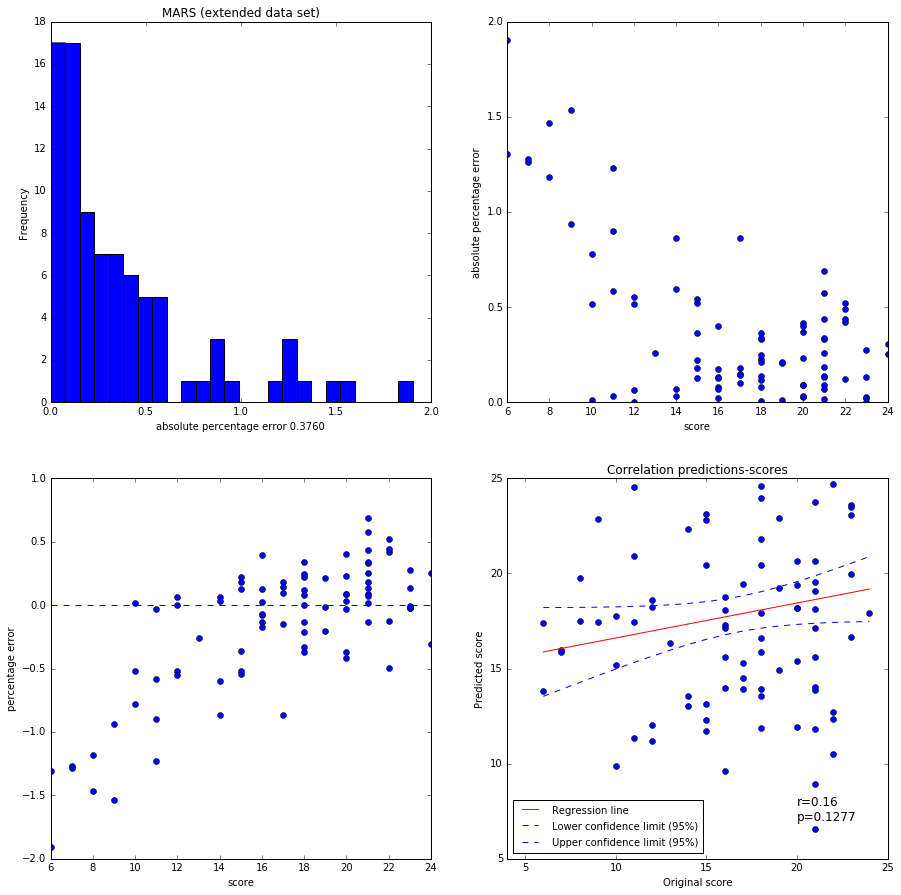

In [32]:
y_true = np.ravel(mars_ext['score'])
y_pred = np.ravel(mars_ext['mars_ext_preds'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['mars_ext'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'MARS (extended data set)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

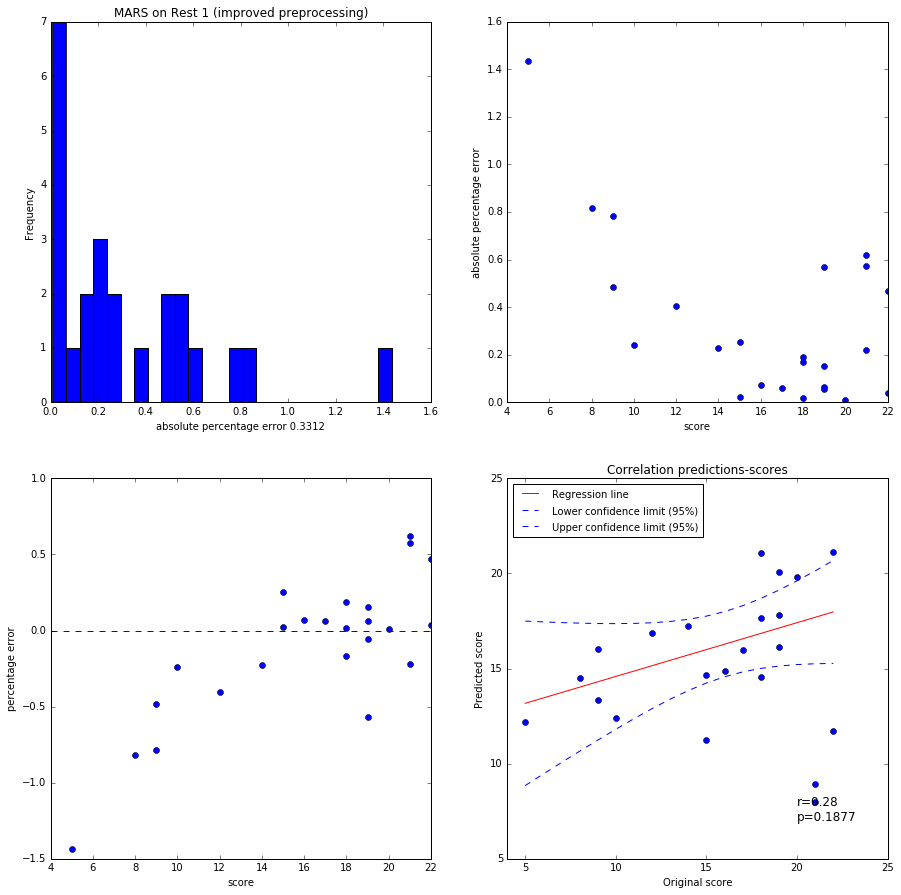

In [33]:
y_true = np.ravel(mars_improved_1['score'])
y_pred = np.ravel(mars_improved_1['mars_improved'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['mars_improved_1'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'MARS on Rest 1 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

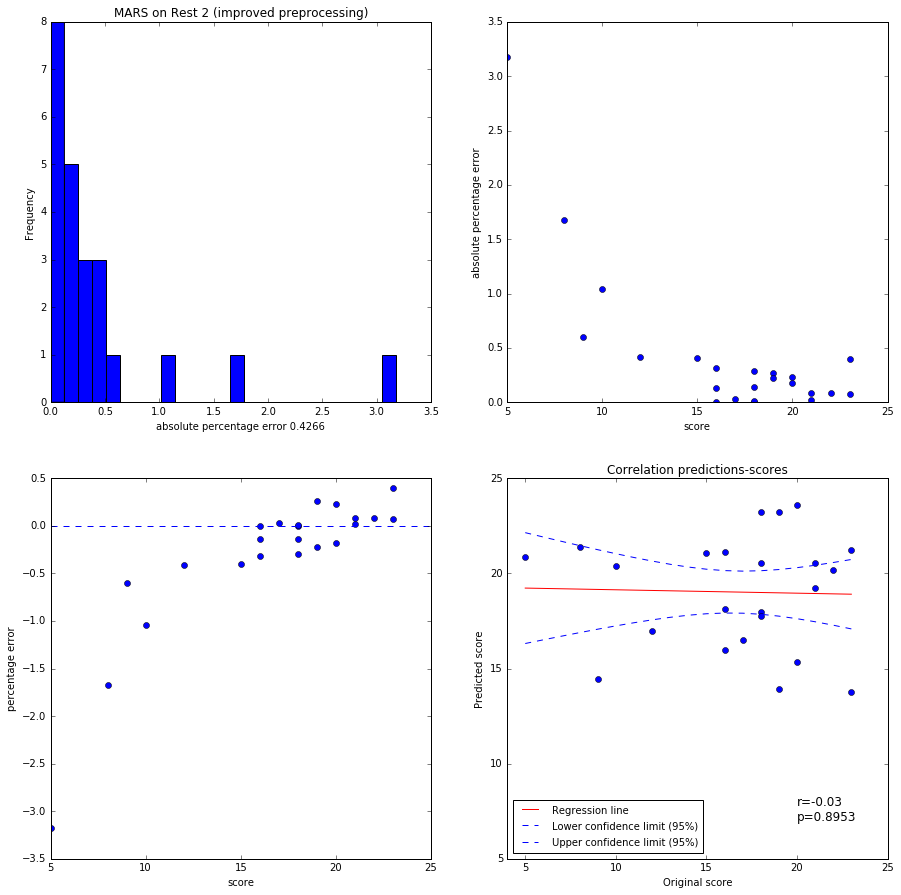

In [34]:
y_true = np.ravel(mars_improved_2['score'])
y_pred = np.ravel(mars_improved_2['mars_improved'])
pe = percentage_error(y_true,y_pred)
ape = absolute_percentage_error(y_true,y_pred)
models['mars_improved_2'] = (y_true,y_pred)
plt.figure(figsize=(15, 15))
plt.subplot(221)
plot_hist(ape,25,'MARS on Rest 2 (improved preprocessing)','absolute percentage error %.4f' % np.mean(ape))
plt.subplot(222)
plot_scatter(y_true,ape,'score','absolute percentage error')
plt.subplot(223)
plot_scatter(y_true,pe,'score','percentage error')
plt.subplot(224)
regression_plot(np.ravel(y_true),np.ravel(y_pred),len(y_pred),'Correlation predictions-scores') 
plt.show()

### Pearson's r, r<sup>2</sup>, MAPE
Comparison among model with respect to:
- Pearson's correlation coefficient between predictions and original scores
- The coefficient of determination r<sup>2</sup> (proportion of explained variance)
- MAPE: Mean Absolute Percentage Error

In [39]:
raw_data = {'model':[m for m in models.keys()],
           'pearson r':[stats.pearsonr(v[1],v[0])[0] for v in models.values()],
           'r squared':[r2_score(v[0],v[1]) for v in models.values()],
           'mape':[mean_absolute_percentage_error(v[0], v[1]) for v in models.values()]}
df = pd.DataFrame(raw_data, columns = ['model', 'pearson r', 'r squared', 'mape'])
df = df.sort_values('model')
print(df)

df_1 = df.loc[df['model'].isin(['svm','randforest','randforest+pca','finn', 'elasticnet','lasso','mars'])].sort_values('model')
df_2 = df.loc[df['model'].isin(['svm_ext','randforest_ext','randforest+pca_ext','finn_ext','elasticnet_ext',
                                'lasso_ext','mars_ext'])].sort_values('model')
df_3 = df.loc[df['model'].isin(['svm_improved_1','randforest_improved_1','randforest+pca_improved_1','finn_improved_1',
                                'elasticnet_improved_1','lasso_improved_1','mars_improved_1'])].sort_values('model')
df_4 = df.loc[df['model'].isin(['svm_improved_2','randforest_improved_2','randforest+pca_improved_2','finn_improved_2',
                                'elasticnet_improved_2','lasso_improved_2','mars_improved_2'])].sort_values('model')




                        model  pearson r  r squared      mape
5                  elasticnet   0.283985   0.079838  0.346184
8              elasticnet_ext   0.213568   0.045022  0.295921
23      elasticnet_improved_1   0.520812   0.230266  0.309314
22      elasticnet_improved_2   0.519524   0.188426  0.294638
16                       finn   0.177759  -0.040612  0.302497
1                    finn_ext   0.138998   0.005733  0.301284
13            finn_improved_1   0.177184  -0.061172  0.304363
12            finn_improved_2   0.315754   0.077948  0.295216
14                      lasso   0.300070   0.086258  0.354015
9                   lasso_ext   0.215249   0.044666  0.294318
26           lasso_improved_1   0.336232   0.084435  0.308631
3            lasso_improved_2   0.519524   0.188426  0.294638
4                        mars   0.120933  -0.960532  0.468701
25                   mars_ext   0.164579  -0.931296  0.376029
15            mars_improved_1   0.278444  -0.466101  0.331208
20      

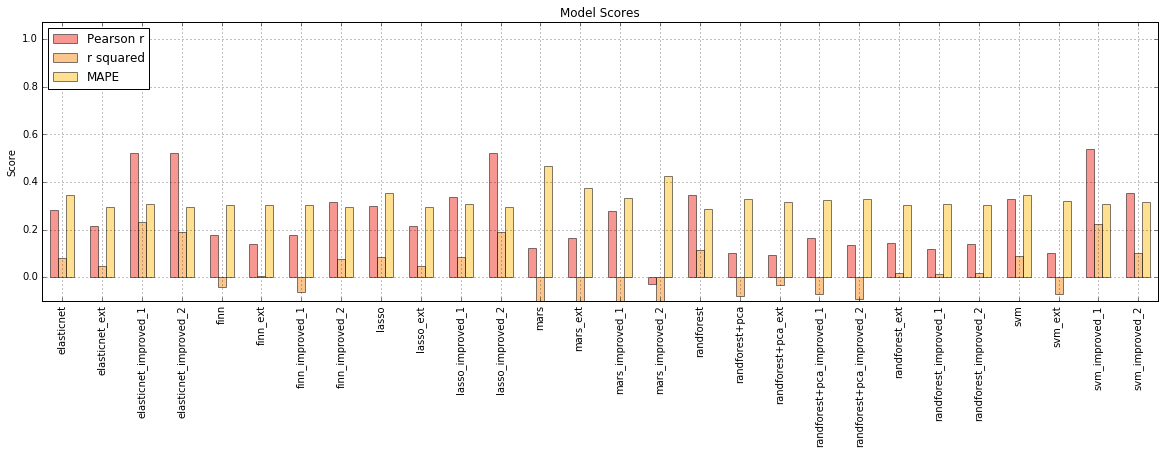

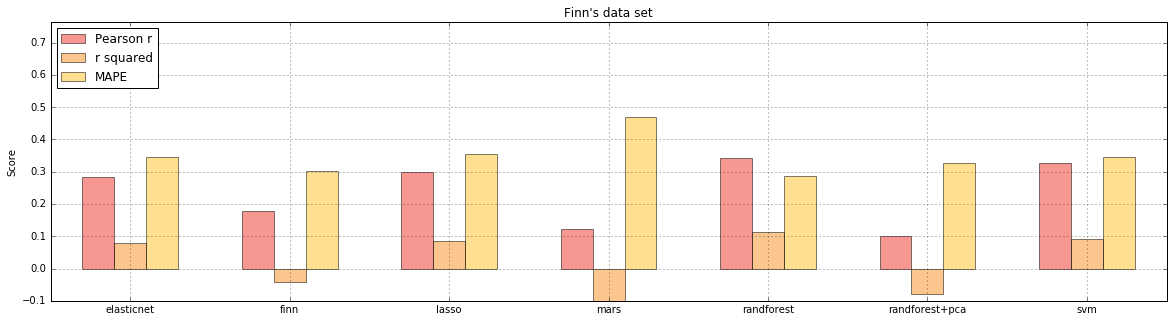

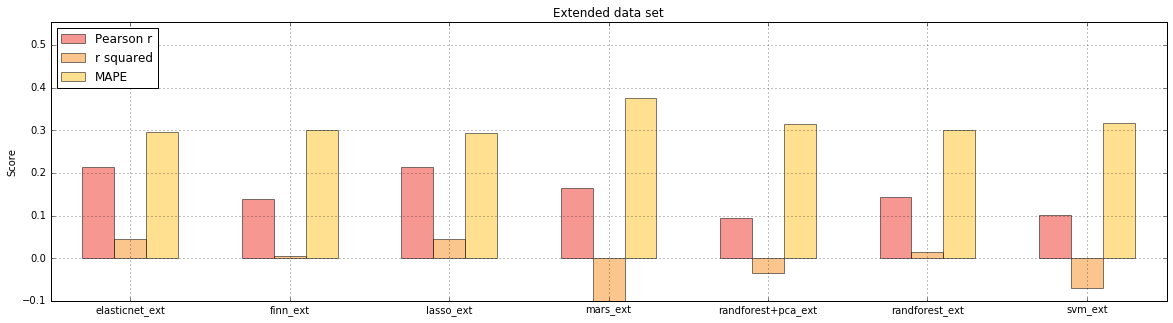

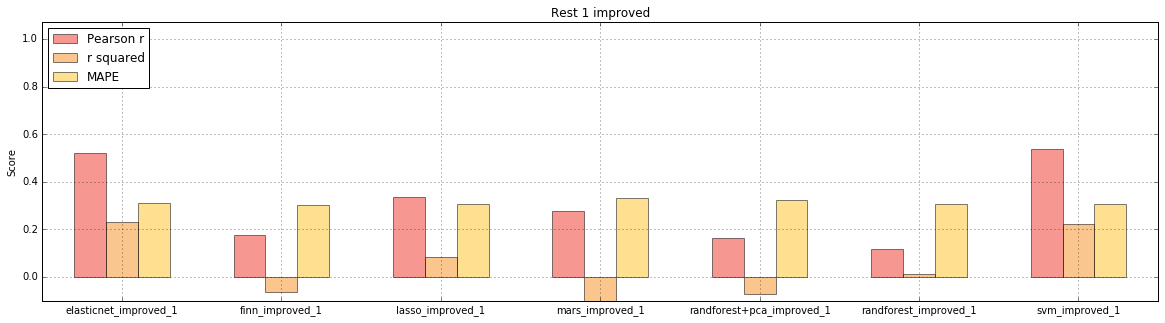

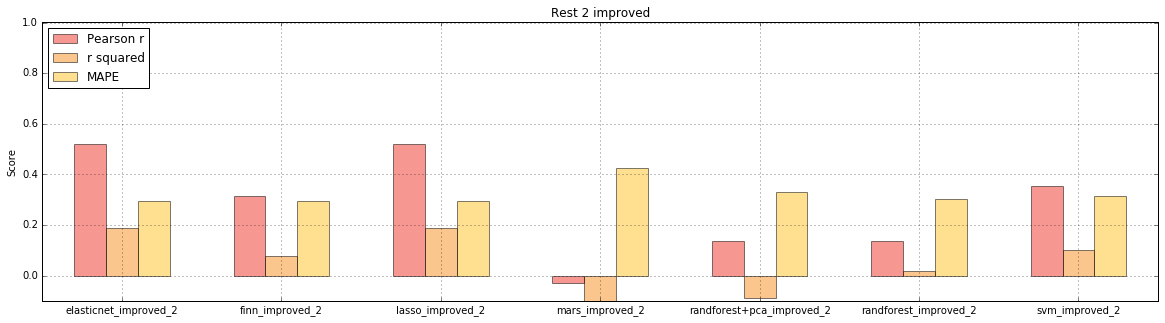

In [40]:
plot_bar_h(df,'Model Scores','vertical')
plot_bar_h(df_1,'Finn\'s data set','horizontal')
plot_bar_h(df_2,'Extended data set','horizontal')
plot_bar_h(df_3,'Rest 1 improved','horizontal')
plot_bar_h(df_4,'Rest 2 improved','horizontal')


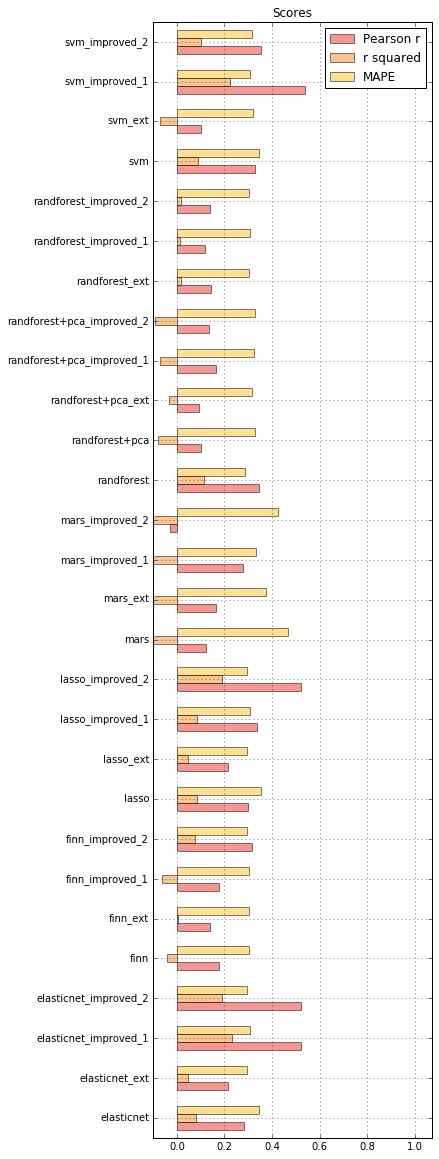

In [41]:
plot_bar_v(df,'Scores')